<a href="https://colab.research.google.com/github/sameer203/Tensorflow_/blob/main/09_transfer_learning_tensorflow_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Oct 27 03:45:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Getting the Data

In [2]:
# helper function
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-10-27 03:45:34--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-10-27 03:45:34 (83.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2021-10-27 03:45:36--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 142.250.107.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   211MB/s    in 7.8s    

2021-10-27 03:45:44 (199 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
unzip_data("101_food_classes_10_percent.zip")

In [6]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/croque_madame'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/frozen_yogurt'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/french_toast'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/ravioli'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/ceviche'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/shrimp_and_grits'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/waffles'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/falafel'.
There are 0 directories and 75 images in '101_fo

In [7]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [8]:
#set up input data
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [9]:
# Create a model checkpoint callback
checkpoint_path = "101_food_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only =False,
                                                         monitor="val_loss",
                                                         save_best_only=True)

In [10]:
# Data Agumentation Layer
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

In [11]:
data_agumentation = Sequential([
                                preprocessing.RandomFlip("horizontal"),
                                preprocessing.RandomRotation(0.2),
                                preprocessing.RandomHeight(0.2),
                                preprocessing.RandomWidth(0.2),
                                preprocessing.RandomZoom(0.2),
                                #preprocessing.Rescaling(1/255.)
], name="data_agumentation")

In [12]:
# Functional API for Efficient Net B0
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

#Set up model with trainable architecture
inputs = layers.Input(shape=(224, 224,3), name="input_layer")
x = data_agumentation(inputs)
x = base_model(x, training = False)
x = layers.GlobalAveragePooling2D(name="Global_Averaging_2D")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)

model = tf.keras.Model(inputs, outputs)


16719872/16705208 [==============================] - 0s 0us/step


In [13]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_agumentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
Global_Averaging_2D (GlobalA (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [14]:
# Compile the model
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [15]:
# Fit the Model
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15*(len(test_data))),
                                           callbacks=[checkpoint_callback]
)

Epoch 1/5
237/237 [==============================] - 66s 182ms/step - loss: 3.4726 - accuracy: 0.2473 - val_loss: 2.6241 - val_accuracy: 0.4092
INFO:tensorflow:Assets written to: 101_food_classes_10_percent_data_model_checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/5
237/237 [==============================] - 38s 156ms/step - loss: 2.3454 - accuracy: 0.4627 - val_loss: 2.2275 - val_accuracy: 0.4584
INFO:tensorflow:Assets written to: 101_food_classes_10_percent_data_model_checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/5
237/237 [==============================] - 35s 147ms/step - loss: 1.9695 - accuracy: 0.5373 - val_loss: 2.0239 - val_accuracy: 0.4931
INFO:tensorflow:Assets written to: 101_food_classes_10_percent_data_model_checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/5
237/237 [==============================] - 35s 144ms/step - loss: 1.7472 - accuracy: 0.5782 - val_loss: 1.9350 - val_accuracy: 0.5053
INFO:tensorflow:Assets written to: 101_food_classes_10_percent_data_model_checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/5
237/237 [==============================] - 34s 141ms/step - loss: 1.6008 - accuracy: 0.6078 - val_loss: 1.8741 - val_accuracy: 0.5193
INFO:tensorflow:Assets written to: 101_food_classes_10_percent_data_model_checkpoint/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [16]:
fine_tuning_result= model.evaluate(test_data)
fine_tuning_result

790/790 [==============================] - 69s 88ms/step - loss: 1.7304 - accuracy: 0.5470


[1.7304184436798096, 0.5470495223999023]

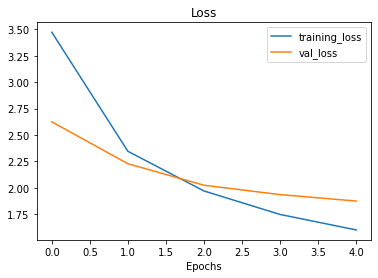

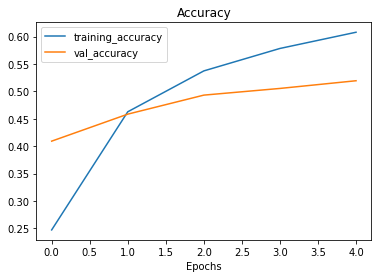

In [17]:
plot_loss_curves(history_all_classes_10_percent)

### Fine tuning

In [18]:
# unfreezing layers
base_model.trainable= True

# Refreeze the layer
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [19]:
# recompile the mode
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [20]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_agumentation True
efficientnetb0 True
Global_Averaging_2D True
output_layer True


In [21]:
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [22]:
fine_tune_epoch = 10

In [63]:
#Refit the Model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                           epochs= fine_tune_epoch,
                                           validation_data=test_data,
                                           validation_steps=int(0.15*(len(test_data))),
                                           initial_epoch=history_all_classes_10_percent.epoch[-1]
)

Epoch 5/10
237/237 [==============================] - 112s 423ms/step - loss: 0.3127 - accuracy: 0.9018 - val_loss: 2.0752 - val_accuracy: 0.5527
Epoch 6/10
237/237 [==============================] - 92s 385ms/step - loss: 0.2217 - accuracy: 0.9333 - val_loss: 2.1831 - val_accuracy: 0.5609
Epoch 7/10
237/237 [==============================] - 88s 368ms/step - loss: 0.1879 - accuracy: 0.9423 - val_loss: 2.2750 - val_accuracy: 0.5625
Epoch 8/10
237/237 [==============================] - 86s 359ms/step - loss: 0.1412 - accuracy: 0.9563 - val_loss: 2.3580 - val_accuracy: 0.5622
Epoch 9/10
237/237 [==============================] - 85s 355ms/step - loss: 0.1285 - accuracy: 0.9632 - val_loss: 2.3981 - val_accuracy: 0.5583
Epoch 10/10
237/237 [==============================] - 82s 345ms/step - loss: 0.1148 - accuracy: 0.9663 - val_loss: 2.5480 - val_accuracy: 0.5482


In [24]:
history_all_classes_10_percent_fine_tune_results = model.evaluate(test_data)

790/790 [==============================] - 68s 86ms/step - loss: 1.6242 - accuracy: 0.5734


In [25]:
history_all_classes_10_percent_fine_tune_results

[1.6242308616638184, 0.5734257698059082]

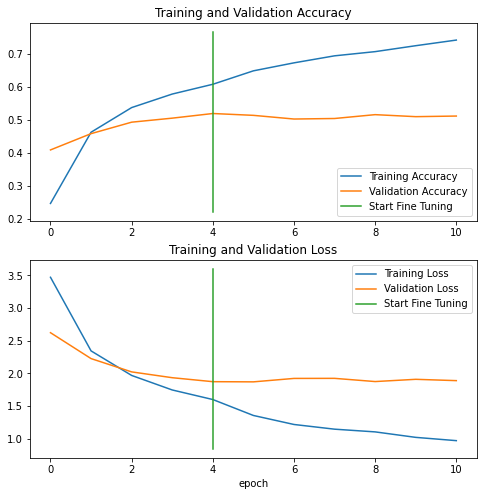

In [26]:
compare_historys(history_all_classes_10_percent, history_all_classes_10_percent_fine_tune)

In [27]:
# saving and loading the model
model.save("101_food_classes_10_percent_model_fine_tuned.h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [28]:
loaded_model = tf.keras.models.load_model("101_food_classes_10_percent_model_fine_tuned.h5")

In [29]:
loaded_model_result = loaded_model.evaluate(test_data)
loaded_model_result

790/790 [==============================] - 69s 85ms/step - loss: 2.1618 - accuracy: 0.4595


[2.161846876144409, 0.45948514342308044]

In [30]:
history_all_classes_10_percent_fine_tune_results

[1.6242308616638184, 0.5734257698059082]

### Evaluating the performance of the model

In [31]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2021-10-27 04:01:07--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.199.128, 74.125.20.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.199.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  92.2MB/s    in 0.5s    

2021-10-27 04:01:08 (92.2 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [32]:
unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

In [33]:
# Load in the pretrained models
model = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [34]:
# Evaluate loaded model
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 70s 87ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027207851409912, 0.6077623963356018]

### Making prediction with the trained model

In [35]:
# Make prediction with model  -probability
preds_prob = model.predict(test_data, verbose=1)

790/790 [==============================] - 68s 84ms/step


In [36]:
# how many predictions are there
len(preds_prob)

25250

In [37]:
preds_prob.shape

(25250, 101)

In [38]:
preds_prob[0], len(preds_prob[0]), sum(preds_prob[0])

(array([5.9542134e-02, 3.5742110e-06, 4.1376989e-02, 1.0660594e-09,
        8.1614573e-09, 8.6639469e-09, 8.0927026e-07, 8.5652727e-07,
        1.9859068e-05, 8.0977821e-07, 3.1727796e-09, 9.8673718e-07,
        2.8532225e-04, 7.8048884e-10, 7.4230251e-04, 3.8916369e-05,
        6.4740229e-06, 2.4977251e-06, 3.7891088e-05, 2.0678401e-07,
        1.5538462e-05, 8.1507005e-07, 2.6230512e-06, 2.0010719e-07,
        8.3827507e-07, 5.4215920e-06, 3.7391094e-06, 1.3150555e-08,
        2.7761490e-03, 2.8051913e-05, 6.8562661e-10, 2.5574802e-05,
        1.6688893e-04, 7.6406981e-10, 4.0452849e-04, 1.3150681e-08,
        1.7957424e-06, 1.4448199e-06, 2.3062952e-02, 8.2466835e-07,
        8.5365667e-07, 1.7138624e-06, 7.0525148e-06, 1.8402163e-08,
        2.8553370e-07, 7.9483289e-06, 2.0681648e-06, 1.8525219e-07,
        3.3619635e-08, 3.1522560e-04, 1.0410960e-05, 8.5448096e-07,
        8.4741843e-01, 1.0555463e-05, 4.4094864e-07, 3.7404097e-05,
        3.5306119e-05, 3.2489061e-05, 6.7314468e

In [39]:
print(f"Number of predicition probabilities for sample 0: {len(preds_prob[0])}")
print(f"what prediction probabilities sample 0 look like :\n {preds_prob[0]}")
print(f"the class with the highest prediction probability by the model for sample0 : {preds_prob[0].argmax()}")

Number of predicition probabilities for sample 0: 101
what prediction probabilities sample 0 look like :
 [5.9542134e-02 3.5742110e-06 4.1376989e-02 1.0660594e-09 8.1614573e-09
 8.6639469e-09 8.0927026e-07 8.5652727e-07 1.9859068e-05 8.0977821e-07
 3.1727796e-09 9.8673718e-07 2.8532225e-04 7.8048884e-10 7.4230251e-04
 3.8916369e-05 6.4740229e-06 2.4977251e-06 3.7891088e-05 2.0678401e-07
 1.5538462e-05 8.1507005e-07 2.6230512e-06 2.0010719e-07 8.3827507e-07
 5.4215920e-06 3.7391094e-06 1.3150555e-08 2.7761490e-03 2.8051913e-05
 6.8562661e-10 2.5574802e-05 1.6688893e-04 7.6406981e-10 4.0452849e-04
 1.3150681e-08 1.7957424e-06 1.4448199e-06 2.3062952e-02 8.2466835e-07
 8.5365667e-07 1.7138624e-06 7.0525148e-06 1.8402163e-08 2.8553370e-07
 7.9483289e-06 2.0681648e-06 1.8525219e-07 3.3619635e-08 3.1522560e-04
 1.0410960e-05 8.5448096e-07 8.4741843e-01 1.0555463e-05 4.4094864e-07
 3.7404097e-05 3.5306119e-05 3.2489061e-05 6.7314468e-05 1.2852564e-08
 2.6219754e-10 1.0318126e-05 8.5744177e-05

In [40]:
test_data.class_names[52]

'gyoza'

In [41]:
pred_classes = preds_prob.argmax(axis=1)

In [42]:
pred_classes[:10],len(pred_classes)

(array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0]), 25250)

In [43]:
test_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 101)), types: (tf.float32, tf.float32)>

In [44]:
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [45]:
len(y_labels)

25250

In [46]:
results_downloaded_model

[1.8027207851409912, 0.6077623963356018]

In [47]:
# check model accuracy with sklearn
from sklearn.metrics import accuracy_score

sklearn_accuracy = accuracy_score(y_labels, pred_classes)

sklearn_accuracy

0.6077623762376237

In [48]:
import numpy as np
np.isclose(results_downloaded_model[1], sklearn_accuracy)

True

In [49]:
# creeate confusion matrix
from helper_functions import make_confusion_matrix

In [50]:
class_names = test_data.class_names

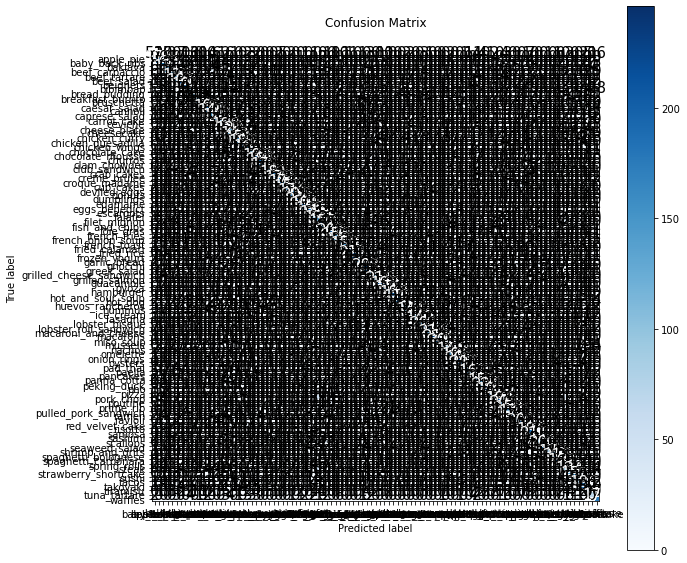

In [51]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names)

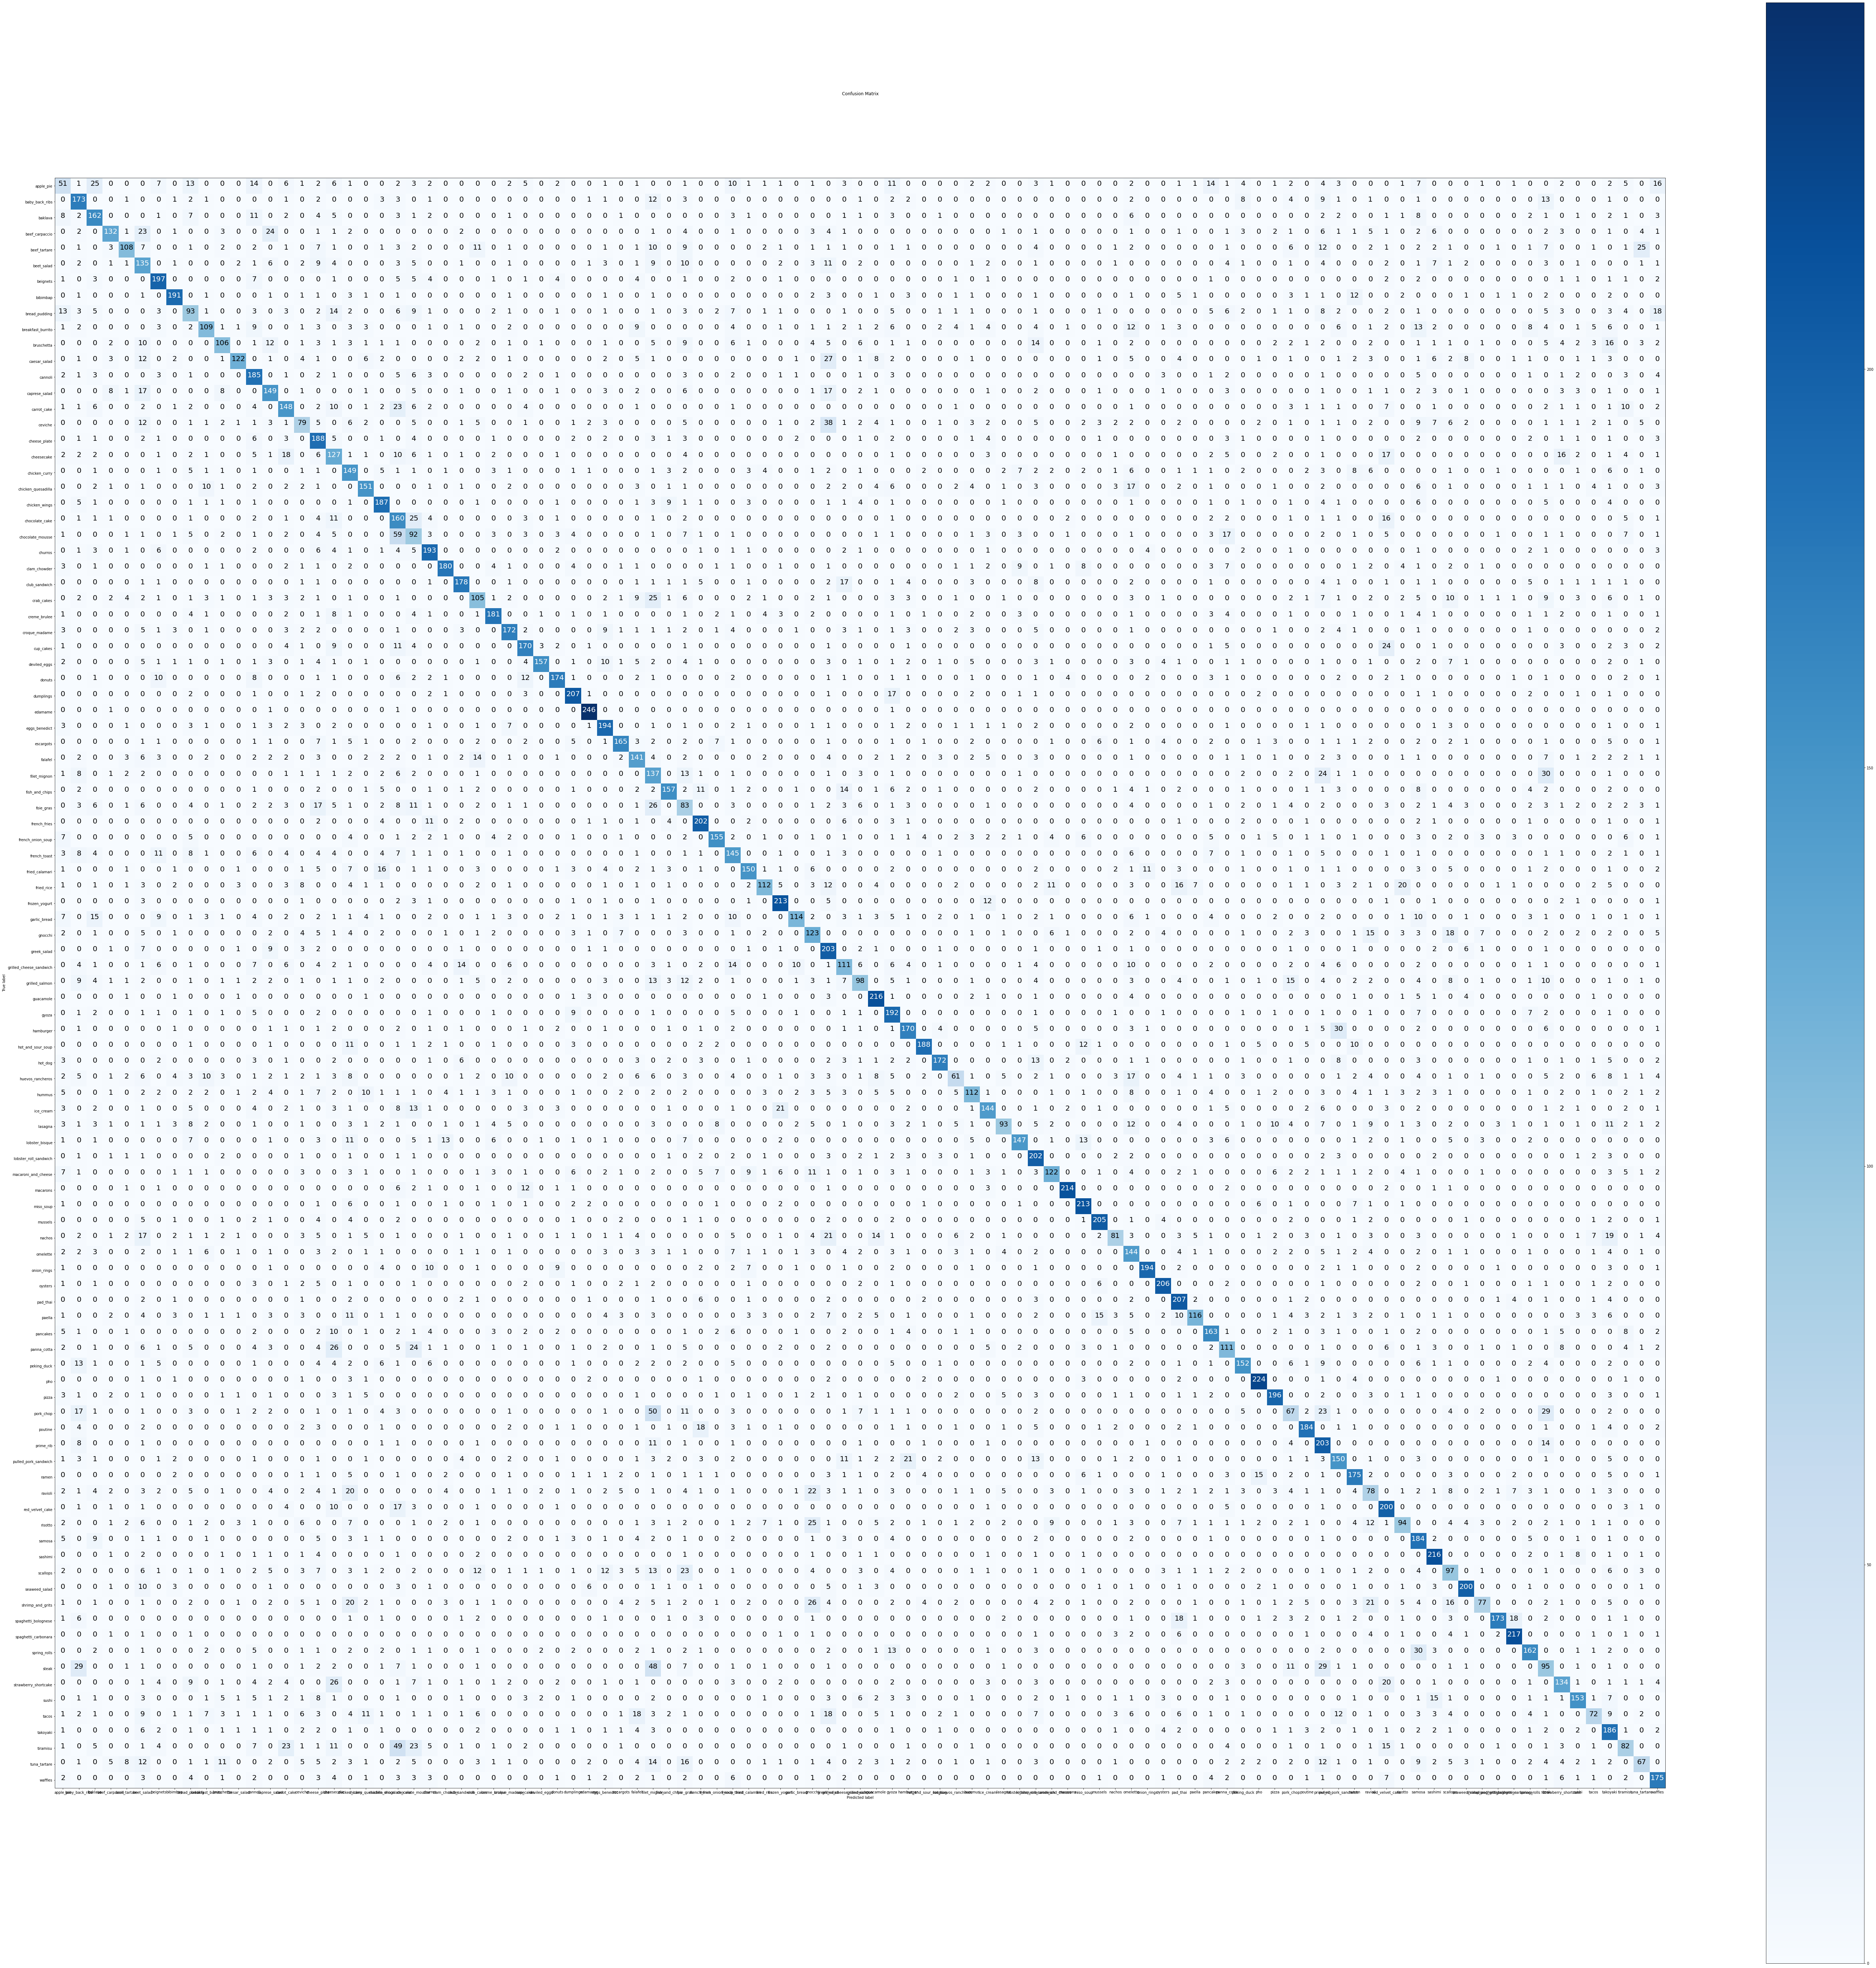

In [52]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100,100),
                      text_size=20)

In [53]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

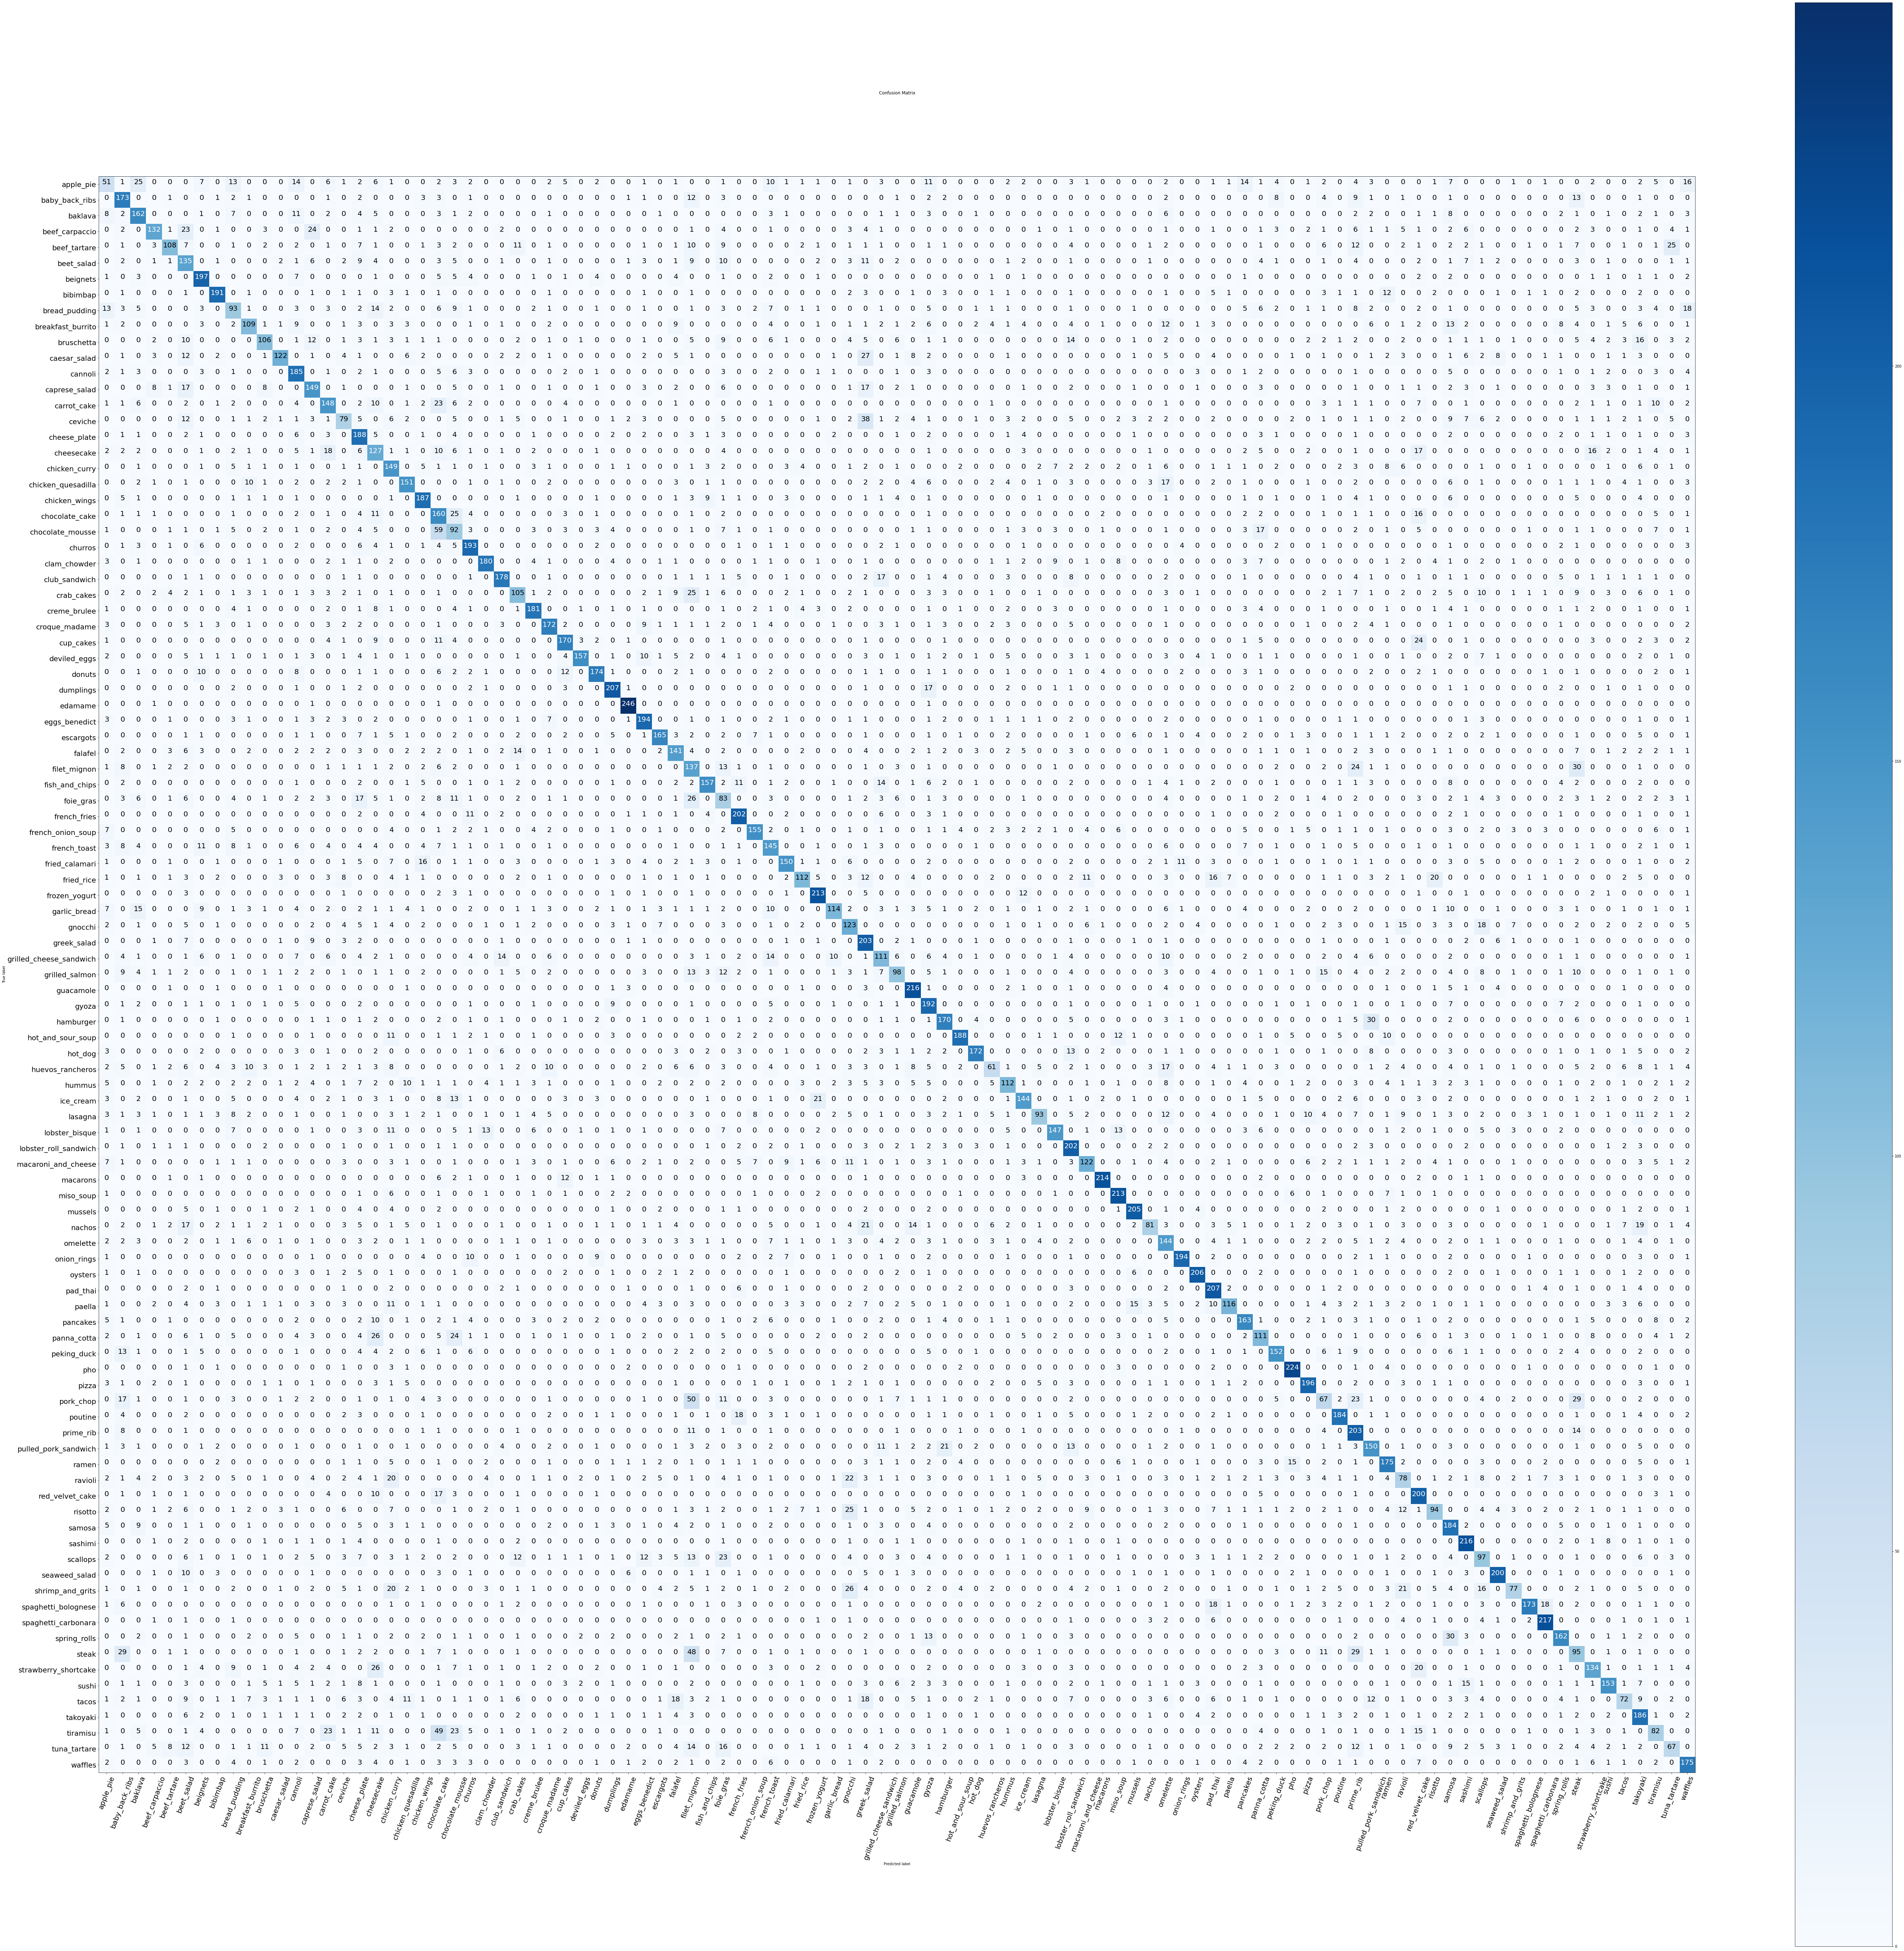

In [54]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [55]:
# sklearn classification report
from sklearn.metrics import classification_report
print(classification_report(y_labels,
                            pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [56]:
# Get a dictionary of classification report
classification_report_dict= classification_report(y_labels, pred_classes,output_dict=True)
classification_report_dict

{'0': {'f1-score': 0.24056603773584903,
  'precision': 0.29310344827586204,
  'recall': 0.204,
  'support': 250},
 '1': {'f1-score': 0.5864406779661017,
  'precision': 0.5088235294117647,
  'recall': 0.692,
  'support': 250},
 '10': {'f1-score': 0.5047619047619047,
  'precision': 0.6235294117647059,
  'recall': 0.424,
  'support': 250},
 '100': {'f1-score': 0.641025641025641,
  'precision': 0.5912162162162162,
  'recall': 0.7,
  'support': 250},
 '11': {'f1-score': 0.6161616161616161,
  'precision': 0.8356164383561644,
  'recall': 0.488,
  'support': 250},
 '12': {'f1-score': 0.6105610561056106,
  'precision': 0.5196629213483146,
  'recall': 0.74,
  'support': 250},
 '13': {'f1-score': 0.5775193798449612,
  'precision': 0.5601503759398496,
  'recall': 0.596,
  'support': 250},
 '14': {'f1-score': 0.574757281553398,
  'precision': 0.5584905660377358,
  'recall': 0.592,
  'support': 250},
 '15': {'f1-score': 0.36744186046511623,
  'precision': 0.4388888888888889,
  'recall': 0.316,
  'su

### Plot F1 score

In [57]:
class_f1_score = {}

for k, v in classification_report_dict.items():
  if k =="accuracy":
    break
  else:
    class_f1_score[class_names[int(k)]] = v["f1-score"]
class_f1_score

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [58]:
import pandas as pd
f1_scores = pd.DataFrame({"class_names":list(class_f1_score.keys()),
                          "f1-score": list(class_f1_score.values())}).sort_values("f1-score", ascending=False)


In [59]:
f1_scores[:-10]

class_names  f1-score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
..                  ...       ...
5            beet_salad  0.418605
87             scallops  0.397541
37         filet_mignon  0.387006
8         bread_pudding  0.386694
98             tiramisu  0.385882

[91 rows x 2 columns]

In [60]:
import matplotlib.pyplot as plt


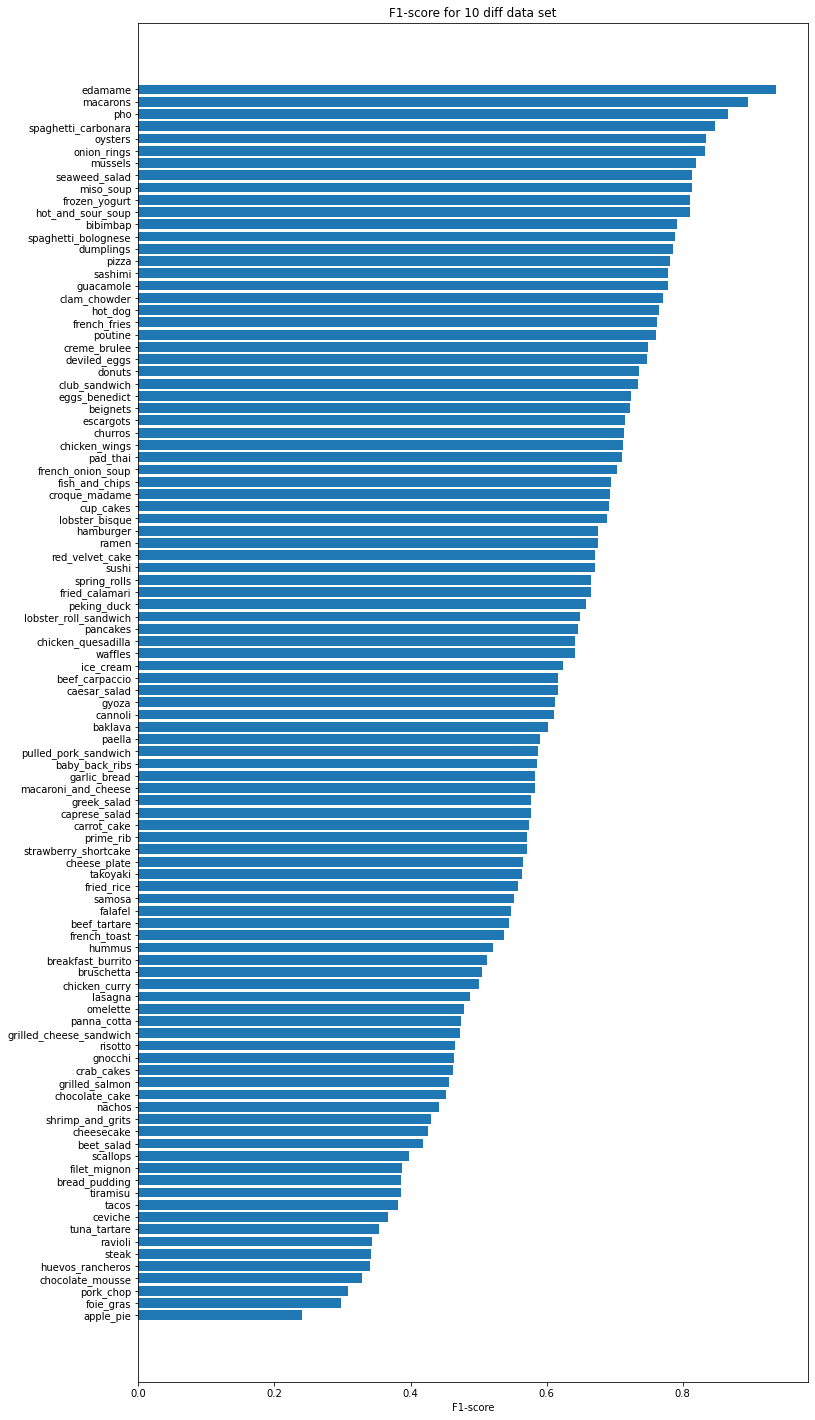

In [61]:
fig, ax  = plt.subplots(figsize=(12, 25))
scores= ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-score for 10 diff data set")
ax.invert_yaxis();

In [62]:
pred_classes

array([ 52,   0,   0, ..., 100,  94, 100])

### Visualizing prediction on test images


In [75]:
# create a function to load and prepareimages
def load_and_prep_image(filename, img_shape=224, scale=True):
  img = tf.io.read_file(filename)
  
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

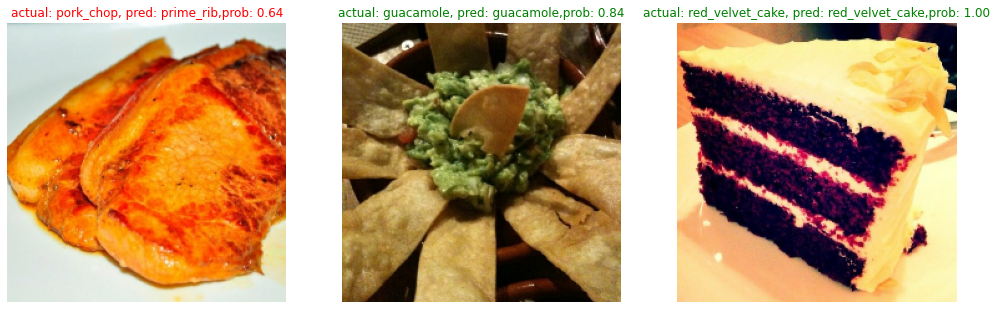

In [95]:
#Make preds on a series of random images
import os
import random

plt.figure(figsize=(17,10))
for i in range(3):
  class_name= random.choice(class_names)
  filename= random.choice(os.listdir(test_dir+ "/" + class_name))
  filepath = test_dir + class_name + "/" + filename
  #print(filepath)
  #load image and prediction
  img = load_and_prep_image(filepath, scale=False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()]

  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class:
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class},prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);